# Introductions

In [12]:
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import scvelo as scv
from tqdm import tqdm

import statsmodels.formula.api as sm
import pandas as pd
from scipy.stats import poisson

In [13]:
from multiprocessing import Pool

def get_s(data):
    gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
    X = data[:,gene_mask]
    n,p = X.shape
    X_cov = np.cov(X,rowvar=False)
    X_mean = np.mean(X,axis=0)
    X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
    s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
    return s

def bootstrap_s(X,B=10,cores=10):
    n,p = X.shape
    Input_args = []
    for b in range(B):
        sample_idx = np.random.choice(n,n,replace=True)
        sample = X[sample_idx]
        Input_args.append(sample)
            
    with Pool(cores) as pool:      
        s = pool.map(get_s, Input_args, chunksize=1)

    return s

In [111]:
def CCC(y_pred, y_true):
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    
    return numerator / denominator

In [ ]:
def select_genes(U,S,gene_names,mean_min=0.1,var_min=1):
    gene_mask = (np.mean(S,axis=0)>0) & (np.mean(U,axis=0)>0) & (np.var(S,axis=0)>0) & (np.var(U,axis=0)>0)
    s = S[:,gene_mask]
    u = U[:,gene_mask]
    gene_names = gene_names[gene_mask]
    cov = np.cov(u,s,rowvar=False)
    s_mean = np.mean(s,axis=0)
    u_mean = np.mean(u,axis=0)
    X_mean = np.append(u_mean,s_mean)
    p = s.shape[1]
    rho = cov/X_mean[:,None]/X_mean[None,:]
    rho_s = rho[p:,p:]
    rho_u = rho[:p,:p]
    rho_us = rho[:p,p:]
    s = (np.sum(rho_us)-np.sum(np.diag(rho_us)))/(p-1)/p
    genes_mask = (s_mean>mean_min) & (u_mean>mean_min) & (np.abs(np.diag(rho_us)-s)>var_min)
    return gene_names[genes_mask]

# Pure RNA + ERCC

In [3]:
pure = pd.read_csv('data/Klein/GSM1599501_K562_pure_RNA.csv',)

In [91]:
var_names = np.array(pure.to_numpy().T[0,],dtype=str)
data = np.array(pure.to_numpy().T[1:,],dtype=float)
data.shape

(953, 25435)

In [92]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.048379452311131985


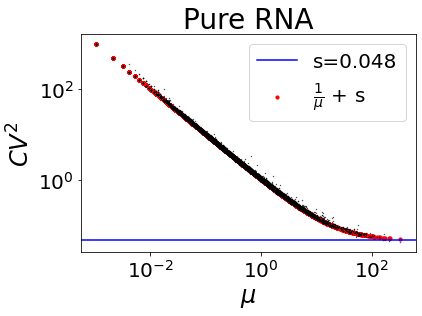

In [93]:
matplotlib.rc('font', size=20)
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("Pure RNA",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend()

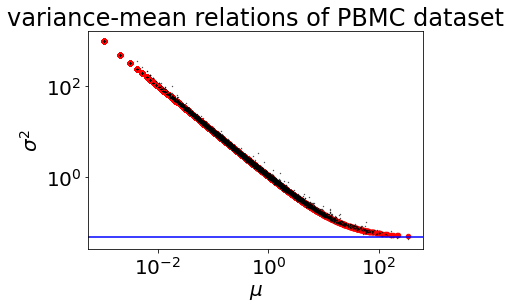

In [94]:
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b')
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma^2$')
plt.title("variance-mean relations of PBMC dataset")
plt.xscale('log')
plt.yscale('log')

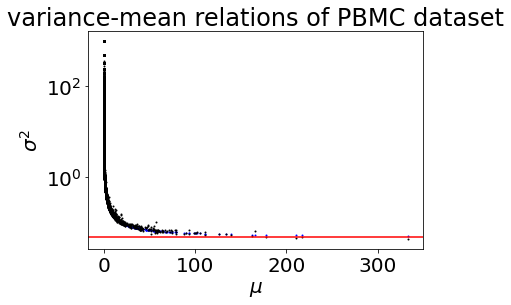

In [95]:
a = 1 
plt.axhline(y=s, c='r')
plt.scatter(X_bar, a/X_bar + s,c='b',alpha=1, s=1)
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=1)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma^2$')
plt.title("variance-mean relations of PBMC dataset")
plt.yscale('log')

## Pgenes

23898


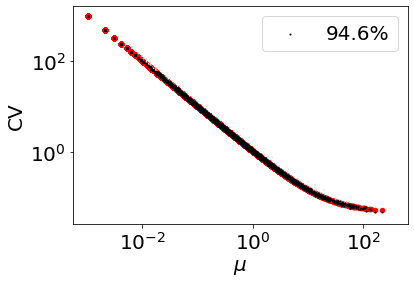

In [96]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

In [98]:
old_Pgenes_s = s
print('old Pgenes_s =', old_Pgenes_s)
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + old_Pgenes_s*X_bar**2)-1)<0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

x=X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)
x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
new_Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('new Pgenes_s =',new_Pgenes_s)

old Pgenes_s = 0.048379452311131985
23898
new Pgenes_s = 0.048044352846043685


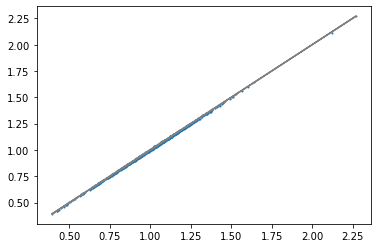

In [11]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(data.sum(axis=1)/data.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),s=1);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');

## Bootstrap

In [12]:
s_bootstrap = bootstrap_s(X,B=100,cores=10)

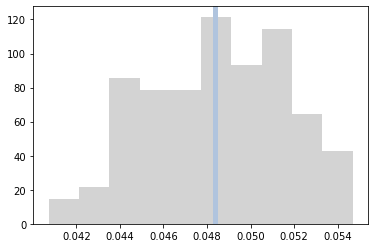

In [13]:
plt.hist(s_bootstrap,color='lightgray',bins=10,density=True)
plt.axvline(x=s,color='lightsteelblue',linewidth=5)

# ES d0

In [22]:
d0 = pd.read_csv('data/Klein/GSM1599494_ES_d0_main.csv',)

In [143]:
data = np.array(d0.to_numpy().T[1:,],dtype=float)
var_names = np.array(d0.to_numpy().T[0,],dtype=str)
data.shape

(933, 24174)

In [144]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.14059093136610992


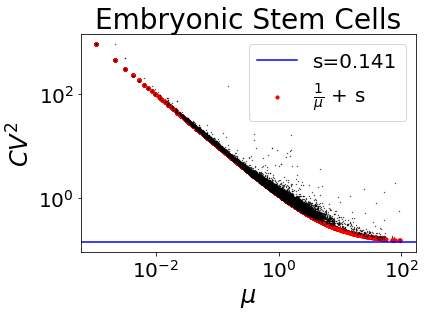

In [145]:
matplotlib.rc('font', size=20)
eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("Embryonic Stem Cells",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend()

14809
Pgenes_s = 0.13973288941803463


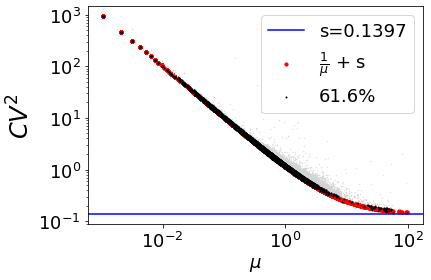

In [146]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

x = X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)

x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('Pgenes_s =',Pgenes_s)

matplotlib.rc('font', size=18)
a = 1 
plt.axhline(y=Pgenes_s, c='b',label='s='+str(np.around(Pgenes_s,4)))
plt.scatter(X_bar, a/X_bar + Pgenes_s ,c='r',alpha=1, s=10, label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$CV^2$',fontsize=24)
plt.xscale('log')
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'Embryonic Stem Cells')

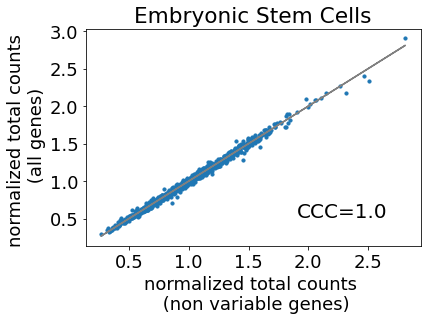

In [147]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(x.sum(axis=1)/x.sum(axis=1).mean(),data.sum(axis=1)/data.sum(axis=1).mean(),s=10);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');
ax.text(0.9, 0.2, "CCC="+str(np.around(CCC(data.sum(axis=1)/data.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean()))), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
ax.set_xlabel("normalized total counts \n (non variable genes)")
ax.set_ylabel("normalized total counts \n (all genes)")
ax.set_title("Embryonic Stem Cells")

In [120]:
s_bootstrap = bootstrap_s(X,B=100,cores=10)

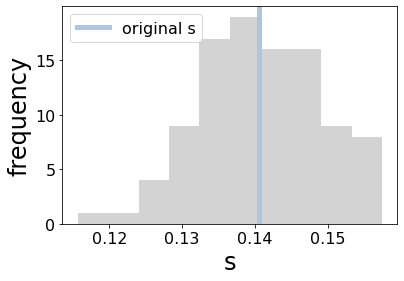

In [133]:
matplotlib.rc('font', size=16)
plt.hist(s_bootstrap,color='lightgray',bins=10)
plt.axvline(x=s,color='lightsteelblue',linewidth=5,label="original s")
plt.xlabel("s",fontsize=24)
plt.ylabel("frequency",fontsize=24)
plt.legend()

# d2

In [76]:
d2 = pd.read_csv('data/Klein/GSM1599497_ES_d2_LIFminus.csv')

In [86]:
data = np.array(d2.to_numpy().T[1:,],dtype=float)
var_names = np.array(d2.to_numpy().T[0,],dtype=str)
data.shape

(303, 24174)

In [87]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.13781806983204858


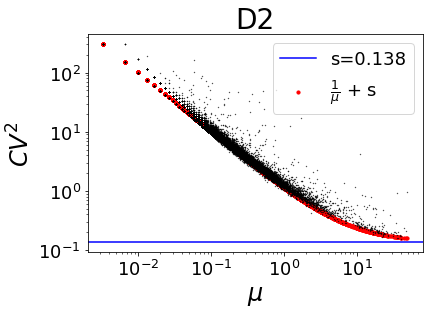

In [88]:
matplotlib.rc('font', size=18)
eta_0 = -1
Ec = 0.04
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("D2",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend()

16673


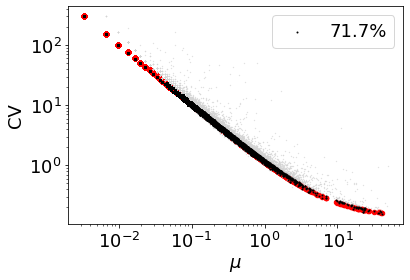

In [89]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

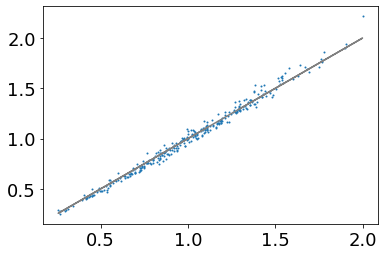

In [90]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(x.sum(axis=1)/x.sum(axis=1).mean(),data.sum(axis=1)/data.sum(axis=1).mean(),s=1);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');

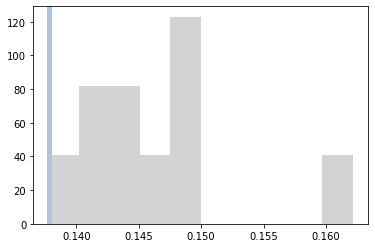

In [28]:
s_bootstrap = bootstrap_s(X,B=10,cores=10)
plt.hist(s_bootstrap,color='lightgray',bins=10,density=True)
plt.axvline(x=s,color='lightsteelblue',linewidth=5)

# d4

In [71]:
d4 = pd.read_csv('data/Klein/GSM1599498_ES_d4_LIFminus.csv',)
data = np.array(d4.to_numpy().T[1:,],dtype=float)
var_names = np.array(d4.to_numpy().T[0,],dtype=str)
data.shape

(683, 24174)

In [72]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.12947372620175726


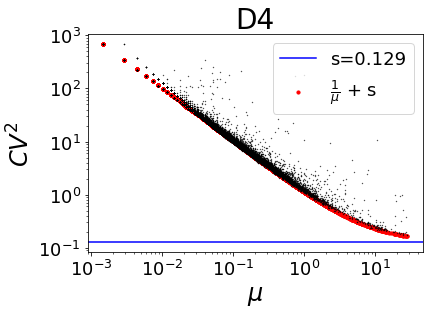

In [73]:
matplotlib.rc('font', size=18)
eta_0 = -1
Ec = 0.04
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("D4",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

19313


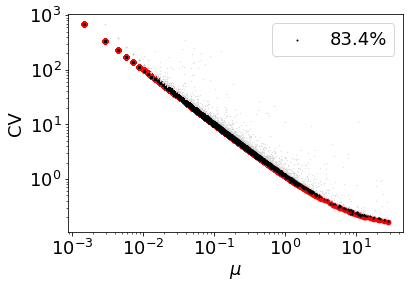

In [75]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

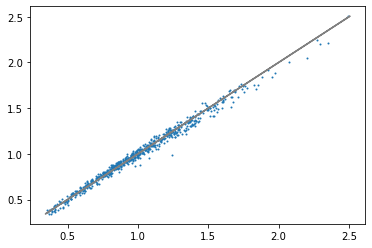

In [32]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(data.sum(axis=1)/data.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),s=1);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');

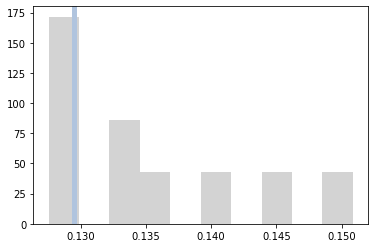

In [33]:
s_bootstrap = bootstrap_s(X,B=10,cores=10)
plt.hist(s_bootstrap,color='lightgray',bins=10,density=True)
plt.axvline(x=s,color='lightsteelblue',linewidth=5)

# d7

In [47]:
d7 = pd.read_csv('data/Klein/GSM1599499_ES_d7_LIFminus.csv',)

(798, 24174)

In [148]:
data = np.array(d7.to_numpy().T[1:,],dtype=float)
var_names = np.array(d7.to_numpy().T[0,],dtype=str)
data.shape

(798, 24174)

In [149]:
gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.3220819722911552


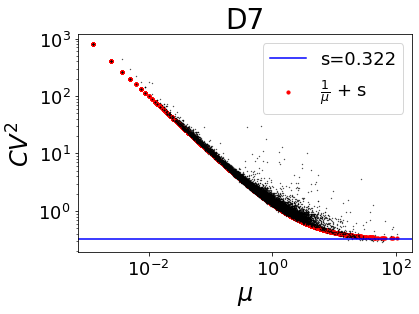

In [150]:
matplotlib.rc('font', size=18)
eta_0 = -1
Ec = 0.04
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b',label='s='+str(np.around(s,3)))
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10,label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=0.1)
plt.xlabel(r'$\mu$',fontsize=24)
plt.ylabel(r'$CV^2$',fontsize=24)
plt.title("D7",fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

14077


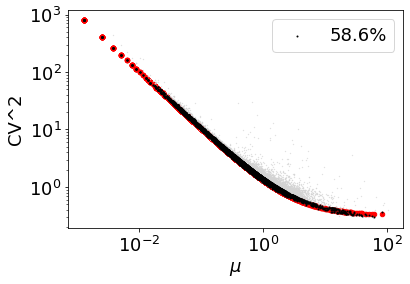

In [151]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + s*X_bar**2)-1) < 0.1)
Pgenes = var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV^2')
plt.xscale('log')
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'D7')

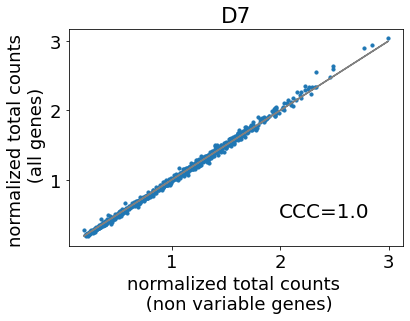

In [152]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(x.sum(axis=1)/x.sum(axis=1).mean(),data.sum(axis=1)/data.sum(axis=1).mean(),s=10);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');
ax.text(0.9, 0.2, "CCC="+str(np.around(CCC(data.sum(axis=1)/data.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean()))), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
ax.set_xlabel("normalized total counts \n (non variable genes)")
ax.set_ylabel("normalized total counts \n (all genes)")
ax.set_title("D7")

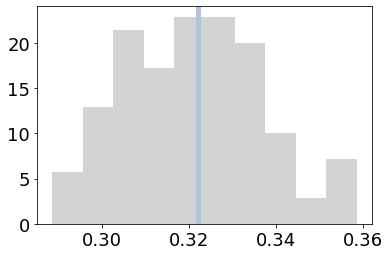

In [153]:
s_bootstrap = bootstrap_s(X,B=100,cores=10)

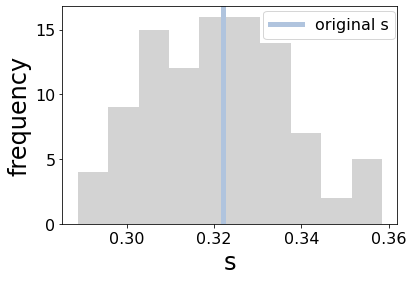

In [160]:
matplotlib.rc('font', size=16)
plt.hist(s_bootstrap,color='lightgray',bins=10)
plt.axvline(x=s,color='lightsteelblue',linewidth=5,label="original s")
plt.xlabel("s",fontsize=24)
plt.ylabel("frequency",fontsize=24)
plt.legend(loc=(0.6,0.85))

# Forebrain

In [161]:
forebrain = sc.read('data/hgForebrainGlut.loom')

In [162]:
data = forebrain.X.toarray()

gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0)
adata = forebrain[:,gene_mask]
X = data[:,gene_mask]

cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

s = 0.20732547085609512


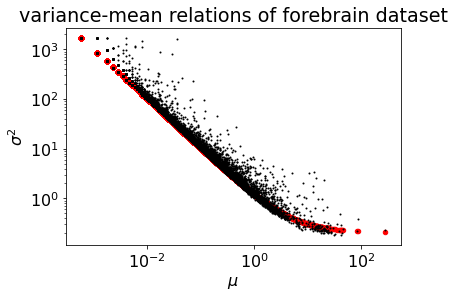

In [163]:
a1 = 1
plt.scatter(X_bar, a1/X_bar + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2, c='k', s=1)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma^2$')
plt.title("variance-mean relations of forebrain dataset")
plt.xscale('log')
plt.yscale('log')

In [164]:
old_Pgenes_s = s
print('old Pgenes_s =', old_Pgenes_s)
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + old_Pgenes_s*X_bar**2)-1)<0.1)
Pgenes = adata.var_names[Pgene_mask]
print(np.sum(Pgene_mask))

x = X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)
x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
new_Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('new Pgenes_s =',new_Pgenes_s)

old Pgenes_s = 0.20732547085609512
14353
new Pgenes_s = 0.18047189720980616


In [165]:
old_Pgenes_s = new_Pgenes_s
print('old Pgenes_s =', old_Pgenes_s)
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + old_Pgenes_s*X_bar**2)-1)<0.1)
Pgenes = adata.var_names[Pgene_mask]
print(np.sum(Pgene_mask))

x = X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)
x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
new_Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('new Pgenes_s =',new_Pgenes_s)

old Pgenes_s = 0.18047189720980616
14313
new Pgenes_s = 0.18040952568211124


14313
Pgenes_s = 0.18040952568211124


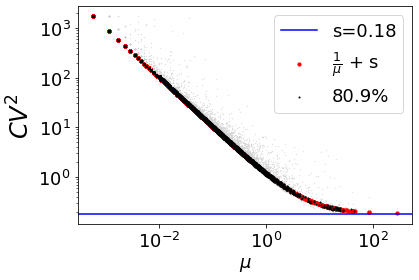

In [168]:
Pgene_mask = (X_bar > 0) & (np.abs(X_var/(a*X_bar + new_Pgenes_s*X_bar**2)-1) < 0.1)
Pgenes = adata.var_names[Pgene_mask]
print(np.sum(Pgene_mask))

x = X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)

x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('Pgenes_s =',Pgenes_s)

matplotlib.rc('font', size=18)
a = 1 
plt.axhline(y=Pgenes_s, c='b',label='s='+str(np.around(Pgenes_s,3)))
plt.scatter(X_bar, a/X_bar + Pgenes_s ,c='r',alpha=1, s=10, label=r'$\frac{1}{\mu}$ + s')
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$CV^2$',fontsize=24)
plt.xscale('log')
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'Forebrain')

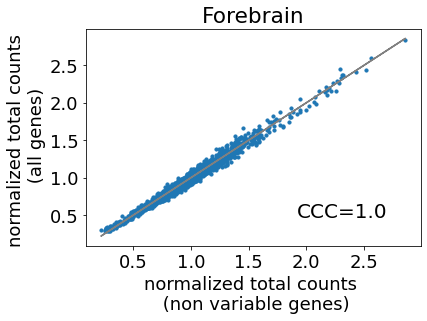

In [169]:
x=X[:,Pgene_mask]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(x.sum(axis=1)/x.sum(axis=1).mean(),data.sum(axis=1)/data.sum(axis=1).mean(),s=10);
ax.plot(x.sum(axis=1)/x.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean(),c='grey');
ax.text(0.9, 0.2, "CCC="+str(np.around(CCC(data.sum(axis=1)/data.sum(axis=1).mean(),x.sum(axis=1)/x.sum(axis=1).mean()))), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
ax.set_xlabel("normalized total counts \n (non variable genes)")
ax.set_ylabel("normalized total counts \n (all genes)")
ax.set_title("Forebrain")

## Clusters

In [178]:
Clusters = set(adata.obs['Clusters'])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

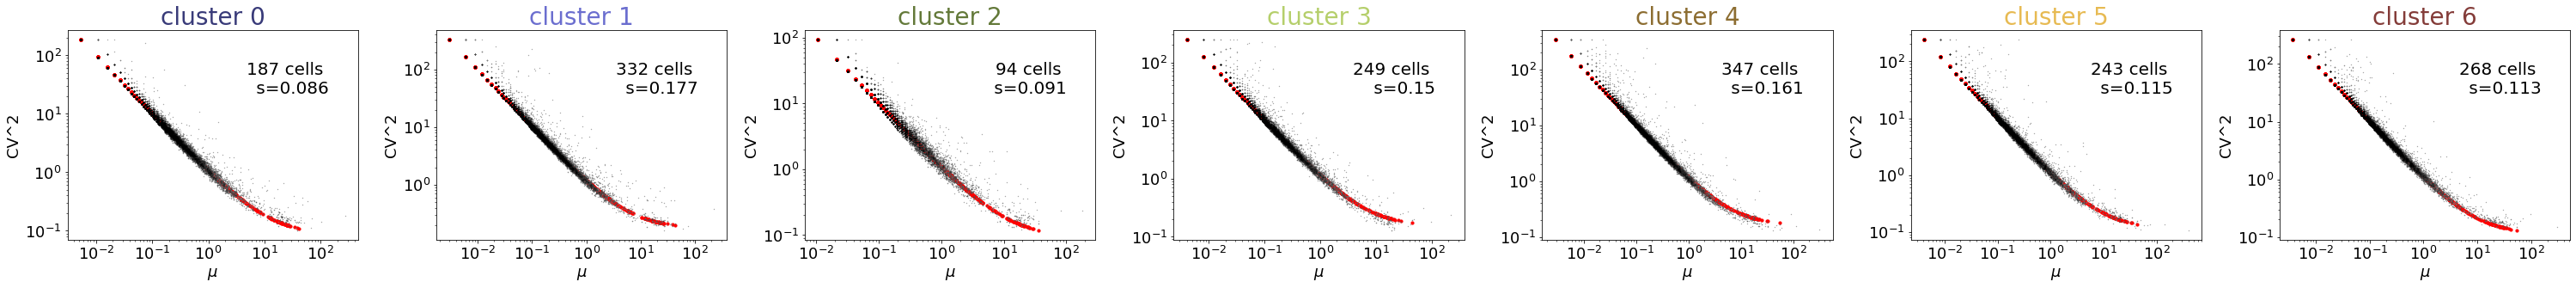

In [183]:
fig, ax = plt.subplots(1,len(Clusters),figsize=(6*len(Clusters),5),tight_layout=True)
for i,cluster in enumerate(Clusters):
    cell_idx = adata.obs['Clusters'].isin([cluster])
    
    cluster_X = adata.X.toarray()[cell_idx]
    cluster_gene_mask = (np.mean(cluster_X,axis=0)>0) & (np.var(cluster_X,axis=0)>0) 
    cluster_X = cluster_X[:,cluster_gene_mask]
    
    gene_idx = adata.var_names[cluster_gene_mask].isin(Pgenes)
    cluster_X_P = cluster_X[:,gene_idx]
    
    cluster_cov = np.cov(cluster_X_P,rowvar=False)
    cluster_X_bar = np.mean(cluster_X_P,axis=0)
    cluster_rho = cluster_cov/cluster_X_bar[:,None]/cluster_X_bar[None,:]
    cluster_s = (np.sum(cluster_rho)-np.sum(np.diag(cluster_rho)))/(len(cluster_rho)-1)/len(cluster_rho)
    #print(cluster, idx.sum(),'s =',s)
    cluster_X_bar = np.mean(cluster_X,axis=0)
    cluster_X_var = np.var(cluster_X,axis=0)
    idx = adata.var_names[cluster_gene_mask].isin(Pgenes)
    
    ax[i].scatter(cluster_X_bar[idx], a1 / cluster_X_bar[idx] + cluster_s, s=10, color='r')
    ax[i].scatter(cluster_X_bar, cluster_X_var/cluster_X_bar**2, s=0.1, color='gray', alpha=1)
    ax[i].scatter(cluster_X_bar[idx], cluster_X_var[idx]/cluster_X_bar[idx]**2, s=1, color='k', alpha=0.1)
    ax[i].text(0.9, 0.85, str(cell_idx.sum())+' cells \n s='+str(np.round(cluster_s,3)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax[i].transAxes, color="black",fontsize=20);
    ax[i].set_xlabel(r'$\mu$')
    ax[i].set_ylabel(r'CV^2')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_title("cluster "+str(i),color=colors20[i],fontsize=28)

In [ ]:
fig, ax = plt.subplots(1,33,figsize=(6*33,4))
for i,gene in enumerate(Pgenes):
    gene_idx = forebrain.var_names.isin([gene])
    x = forebrain.X.toarray()[:,gene_idx]
    ax[i].set_title(gene)
    for cluster in range(5,7): #Clusters:
        cell_idx = forebrain.obs['Clusters'].isin([cluster])
        ax[i].hist(x[cell_idx],bins=np.arange(0,2+np.amax(x),2),alpha=0.3,density=True,color=colors20[cluster])
        ax[i].axvline(x[cell_idx].mean(),color=colors20[cluster],label=cluster)
        
plt.legend();

In [ ]:
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

fig, ax = plt.subplots(1,33,figsize=(6*33,4))
for i,gene in enumerate(Pgenes):
    gene_idx = forebrain.var_names.isin([gene])
    S = forebrain.X.toarray()[:,gene_idx]
    U = forebrain.layers['unspliced'].toarray()[:,gene_idx]
    ax[i].set_title(gene)
    for cluster in range(5,7): #Clusters:
        cell_idx = forebrain.obs['Clusters'].isin([cluster])
        ax[i].plot(U[cell_idx],S[cell_idx],'.',alpha=0.3,color=colors20[cluster])
        
plt.legend();

In [ ]:
from scipy.stats import kruskal

for i,gene in enumerate(Pgenes):
    gene_idx = forebrain.var_names.isin([gene])
    x = forebrain.X.toarray()[:,gene_idx]
    samples =[]
    for cluster in range(5,7):
        cell_idx = forebrain.obs['Clusters'].isin([cluster])
        samples.append(x[cell_idx].reshape((-1)))
    print(kruskal(*samples))

# Amadei

In [ ]:
timepoints = adata.obs['timepoint']
N_idx = np.array([timepoint[0]=='N' for timepoint in timepoints],dtype=bool)
NE = adata[N_idx]
iETX = adata[~N_idx]

In [ ]:
data = NE.layers["spliced"].toarray()

gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b')
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10)
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=1)
plt.xlabel(r'mean',fontsize=24)
plt.ylabel('CV',fontsize=24)
plt.xscale('log')
plt.yscale('log')

In [ ]:
data = iETX.layers["spliced"].toarray()

gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b')
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10)
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=1)
plt.xlabel(r'mean',fontsize=24)
plt.ylabel('CV',fontsize=24)
plt.xscale('log')
plt.yscale('log')

In [ ]:
data = NE.layers["spliced"][NE.obs['celltype'].isin(['Epiblast'])].toarray()

gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b')
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10)
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=1)
plt.xlabel(r'mean',fontsize=24)
plt.ylabel('CV',fontsize=24)
plt.xscale('log')
plt.yscale('log')

In [ ]:
data = NE.layers["spliced"][NE.obs['celltype'].isin(['Definitive endoderm'])].toarray()

gene_mask = (np.mean(data,axis=0)>0) & (np.var(data,axis=0)>0) 
X = data[:,gene_mask]
cov = np.cov(X,rowvar=False)
X_bar = np.mean(X,axis=0)
X_var = np.diag(cov)

rho = cov/X_bar[:,None]/X_bar[None,:]
s = (np.sum(rho)-np.sum(np.diag(rho)))/(len(rho)-1)/len(rho)
print('s =',s)

eta_0 = -1
Ec = 0.071
a = 1 + Ec * (s + 1) * (1 + eta_0)
plt.axhline(y=s, c='b')
plt.scatter(X_bar, a/X_bar + s,c='r',alpha=1, s=10)
plt.scatter(X_bar, X_var/X_bar**2,c='k',alpha=1, s=1)
plt.xlabel(r'mean',fontsize=24)
plt.ylabel('CV',fontsize=24)
plt.xscale('log')
plt.yscale('log')

In [ ]:
old_Pgenes_s = s
print('old Pgenes_s =', old_Pgenes_s)

CV = X_var/(a*X_bar + s*X_bar**2)

Pgene_mask = (X_bar > 0) & (np.abs(CV-1) < 0.5)
Pgenes = adata.var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

x=X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)
x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
new_Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('new Pgenes_s =',new_Pgenes_s)

In [ ]:
old_Pgenes_s = new_Pgenes_s
print('old Pgenes_s =', old_Pgenes_s)

CV = X_var/(a*X_bar + old_Pgenes_s*X_bar**2)

Pgene_mask = (X_bar > 0) & (np.abs(CV-1) < 0.5)
Pgenes = adata.var_names[gene_mask][Pgene_mask]
print(np.sum(Pgene_mask))

x=X[:,Pgene_mask]
x_cov = np.cov(x,rowvar=False)
x_bar = np.mean(x,axis=0)
x_var = np.diag(x_cov)
x_rho = x_cov/x_bar[:,None]/x_bar[None,:]
new_Pgenes_s = (np.sum(x_rho)-np.sum(np.diag(x_rho)))/(len(x_rho)-1)/len(x_rho)
print('new Pgenes_s =',new_Pgenes_s)